## Single-pass Mesh Registration from 3D Scans (FAUST evaluation)

![Teaser Image](../faust_examples.gif)



#### This notebook will:

#### 1. Load and process [FAUST dataset](http://faust.is.tue.mpg.de/) (you will need to download it first);
#### 2. Convert FAUST scans into BPS representation (see [Section 3.1](https://arxiv.org/pdf/1908.09186.pdf) of the original paper for details);
#### 3. Define and load pre-trained BPS mesh registration model (see [Section 5.2](https://arxiv.org/pdf/1908.09186.pdf));
#### 4. Run the model on converted FAUST scans;
#### 5. Visualize the results;
#### 6. Compute the correspondences for test FAUST scans for the final evaluation.

#### You can also download the results of this notebook (predicted alignments, computed correspondeces, demo video) from [here](https://www.dropbox.com/s/gvo2hyvh6okwty3/faust_logs.zip?dl=0). Demo video is also available [here](https://www.dropbox.com/s/2ir8p4m24tm8cpj/faust_test_demo.mp4?dl=0)

### 0. Download [FAUST dataset](http://faust.is.tue.mpg.de/) and [checkpoint model](https://www.dropbox.com/s/u3d1uighrtcprh2/mesh_regressor.h5?dl=0) ([mirror](https://drive.google.com/open?id=19uJp7jeQRdx3rviE7VFD5GkglxvFbzfh)), change the corresponding paths + install dependecies (trimesh, pyntcloud, pillow)

In [1]:
# change this to your actual data path!
FAUST_DATA_PATH = '../data/MPI-FAUST/'
CKPT_DATA_PATH = '../data/mesh_regressor.h5'

# all the results will be saved here
LOG_DIR = '../logs'

In [ ]:
!pip install pyntcloud trimesh pillow

### 1. Load [FAUST dataset](http://faust.is.tue.mpg.de/) (please download it first, registration is needed)

In [2]:
import faust

train_scans, train_meshes = faust.get_faust_train(FAUST_DATA_PATH)
test_scans = faust.get_faust_test(FAUST_DATA_PATH)

100%|██████████| 200/200 [00:37<00:00,  5.34it/s]


### 2. Convert FAUST to BPS representation 

In [3]:
from bps import bps

BPS_RADIUS = 1.7
N_BPS_POINTS = 1024
MESH_SCALER = 1000

xtr, xtr_mean, xtr_max = bps.normalize(train_scans, max_rescale=False, return_scalers=True)
ytr = bps.normalize(train_meshes, x_mean=xtr_mean, x_max=xtr_max, known_scalers=True, max_rescale=False)
xtr_bps = bps.encode(xtr, radius=BPS_RADIUS, n_bps_points=N_BPS_POINTS, bps_cell_type='dists')

xte, xte_mean, xte_max = bps.normalize(test_scans, max_rescale=False, return_scalers=True)
xte_bps = bps.encode(xte, radius=BPS_RADIUS, n_bps_points=N_BPS_POINTS, bps_cell_type='dists')

using 4 available CPUs for BPS encoding..


100%|██████████| 25/25 [00:01<00:00, 23.08it/s]


using 4 available CPUs for BPS encoding..


100%|██████████| 50/50 [00:01<00:00, 37.70it/s]


### 3. Define and load the pre-trained model (please download the checkpoint from [here](https://www.dropbox.com/s/u3d1uighrtcprh2/mesh_regressor.h5?dl=0), [mirror](https://drive.google.com/open?id=19uJp7jeQRdx3rviE7VFD5GkglxvFbzfh))

![Teaser Image](../bps_demo.png)

In [4]:
from mesh_regressor_model import MeshRegressorMLP
import torch

model = MeshRegressorMLP(n_features=N_BPS_POINTS)

model.load_state_dict(torch.load(CKPT_DATA_PATH, map_location='cpu'))

model.eval()

MeshRegressorMLP(
  (bn0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=2048, out_features=1024, bias=True)
  (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (bn4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=3072, out_features=20670, bias=True)
)

### 4. Run the model on FAUST data

In [7]:
import os
import numpy as np
from chamfer_distance import chamfer_distance

if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)

yte_preds = model(torch.Tensor(xte_bps)).detach().numpy() 
yte_preds /= MESH_SCALER

scan2mesh_losses = []
for fid in range(0, len(yte_preds)):
    yte_preds[fid] += xte_mean[fid] #bring back center of the mass after prediction
    scan2mesh_losses.append(MESH_SCALER*chamfer_distance(yte_preds[fid], xte[fid]+xte_mean[fid], direction='y_to_x'))

alignments_path = os.path.join(LOG_DIR, 'alignments.npy')
np.save(alignments_path, yte_preds)

print("FAUST test set scan-to-mesh distance (avg): %4.2f mms" % np.mean(scan2mesh_losses))

FAUST test set scan-to-mesh distance (avg): 15.08 mms


### 5. Visualize predicted meshes

In [ ]:
from tqdm import tqdm

N_TEST_SCANS = 200

smpl_faces = np.loadtxt('../bps_demos/smpl_mesh_faces.txt')

for sid in tqdm(range(0, N_TEST_SCANS)):
    
    mesh_verts = yte_preds[sid]
    scan2mesh_loss = scan2mesh_losses[sid]
    mesh_scan = faust.get_faust_scan_by_id(FAUST_DATA_PATH, sid, 'test')
    
    faust.visualise_predictions(scan=mesh_scan, align_verts=mesh_verts, align_faces=smpl_faces, 
                                scan_id=sid, scan2mesh_loss=scan2mesh_loss, save_dir=LOG_DIR)
    

Predicted alignments meshes saved in: ../logs/faust_test_images
Predicted alignments images saved in: ../logs/faust_test_alignments


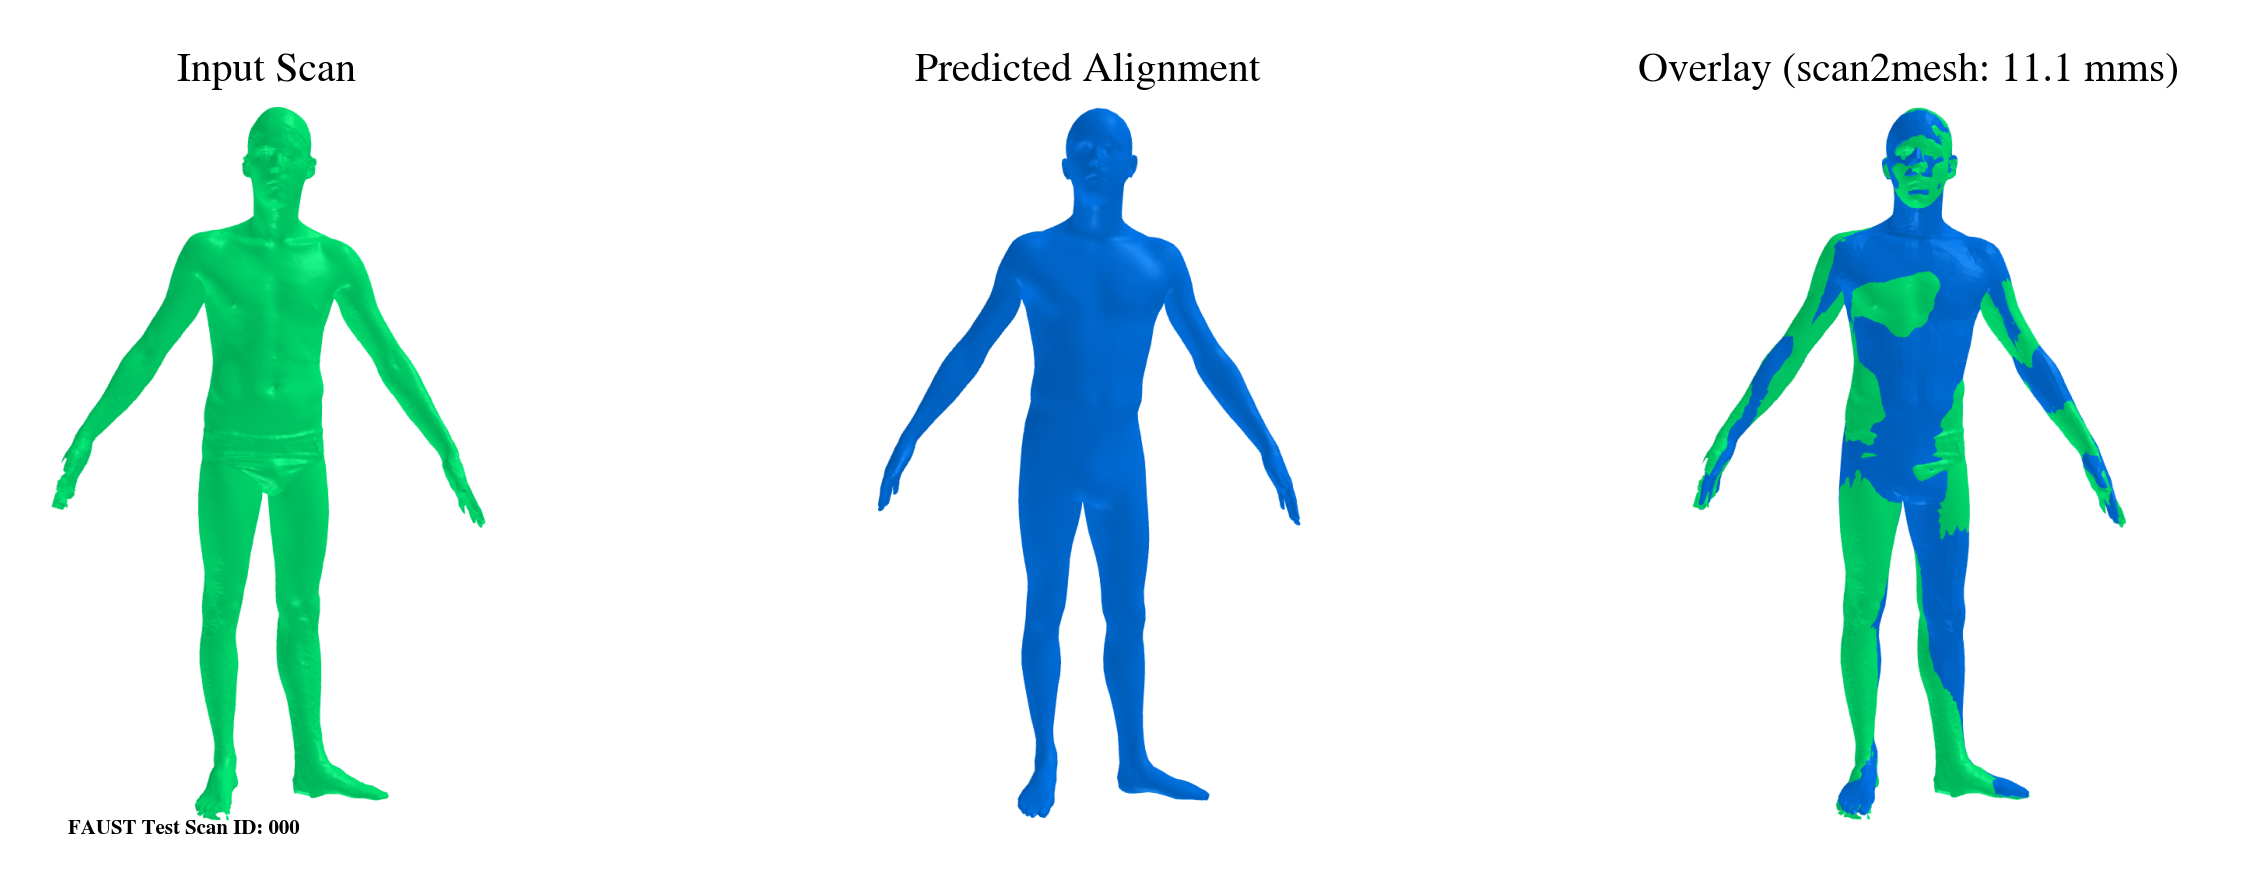

In [12]:
import PIL

images_dir = os.path.join(LOG_DIR, 'faust_test_images')
aligns_dir =  os.path.join(LOG_DIR, 'faust_test_alignments')
print("Predicted alignments meshes saved in: %s" % images_dir)
print("Predicted alignments images saved in: %s" % aligns_dir)

fid = 0
merged_img_path =  os.path.join(images_dir, '%03d_scan_align_pair.png'%fid)
PIL.Image.open(merged_img_path)

#### Optional: make demo video with all test predictions

In [14]:
PREDICTIONS_VIDEO_PATH = os.path.join(LOG_DIR, 'faust_test_demo.mp4')
ffmpeg_cmd = 'ffmpeg -framerate 0.5 -pattern_type glob -i \'%s/*.png\' -vcodec h264 -pix_fmt yuv420p -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2"  %s' % (images_dir, PREDICTIONS_VIDEO_PATH)
os.system(ffmpeg_cmd)
print("video with predictions is saved at : %s" % PREDICTIONS_VIDEO_PATH)

# to generate gif you can run this on a few selected output images:
# convert -delay 150  -loop 0 *.png  faust_examples.gif

video with predictions is saved at : ../logs/faust_test_demo.mp4


### 6. Compute correspondences for FAUST test pairs
##### For this you will need to install  psbody-mesh library. Follow the instructions here: https://github.com/MPI-IS/mesh
##### Produced correspondences achieve 2.631cm/4.785cm average error on INTRA/INTER challenges respectively.

In [16]:
INTRA_SAVE_PATH = os.path.join(LOG_DIR, 'intra')
INTER_SAVE_PATH = os.path.join(LOG_DIR, 'inter')

faust.compute_faust_correspondences(yte_preds, faust_data_path=FAUST_DATA_PATH, output_dir=INTRA_SAVE_PATH, mesh_faces=smpl_faces, mode='intra')
faust.compute_faust_correspondences(yte_preds, faust_data_path=FAUST_DATA_PATH, output_dir=INTER_SAVE_PATH, mesh_faces=smpl_faces, mode='inter')

INTRA_ZIP_PATH = os.path.join(LOG_DIR, 'intra.zip')
INTER_ZIP_PATH = os.path.join(LOG_DIR, 'inter.zip')

os.system('zip -r %s %s' % (INTRA_ZIP_PATH, INTRA_SAVE_PATH))
os.system('zip -r %s %s' % (INTER_ZIP_PATH, INTER_SAVE_PATH))

print("FAUST-INTRA test submission archive saved at: %s" % INTRA_ZIP_PATH)
print("FAUST-INTER test submission archive saved at: %s" % INTER_ZIP_PATH)

60it [01:41,  1.69s/it]
40it [01:08,  1.71s/it]


FAUST-INTRA test submission archive saved at: ../logs/intra.zip
FAUST-INTER test submission archive saved at: ../logs/inter.zip
